<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/audio/beat_tracking_and_tempo_from_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Beat tracking is the task of defining the points in time where a human listener would tap the beat if listening to a song.

**Beat**

> Sequence of equally spaced impulses, which periodically occur in
music. The perceptually most salient pulse (foot tapping rate)


**Tempo**
>  tempo refers to the rate of the musical beat and is given by the reciprocal of the beat period. Tempo is often defined in units of beats per minute (BPM).

Both tempo and beats are fundamental property of a music

**Note onset**

> When playing a note on an instrument such as a piano, there is often a sudden increase of energy at the beginning of a musical tone. 

> **attack** of a note refers to the phase where the sound builds up, which typically goes along with a sharply increasing amplitude envelope. 

> **transient** refers to a noise-like sound component of short duration and high amplitude typically occurring at the beginning of a musical tone

> **onset** of a note refers to the single instant (rather than a period) that marks the beginning of the transient, or the earliest time point at which the transient can be reliably detected.

> It can be formulated as an acoustic event detection problem with the signal under processing being a piece of music and the
events being the note onsets. <br>

> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/audio_note.png' width=250>

> onset candidates may be determined by locating time positions where the signal's amplitude envelope starts increasing.


> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/onsets_examples_1.png' width=450>

> When there is no clear attack phase, such as for nonpercussive music with soft onsets and blurred note transitions, the detection of onsets is much more challenging. For example, the waveform of a violin sound may exhibit a slow energy increase rather than an abrupt change as in a piano sound. For soft sounds, it is hard to determine or even to define the exact onset position. 

> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/onsets_examples_2.png' width=450>

> The detection of individual note onsets becomes even harder when dealing with complex polyphonic music. Simultaneously occurring sound events may result in masking effects, where no significant changes in the signal's energy are measurable. 

> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/onsets_examples_3.png' width=450>


> Eg.Tapping of foot in music

> <img src='https://raw.githubusercontent.com/pankajr141/experiments/master/images/audio_beattracking/another_one_bite.png' width=450>




**challenges -** 
1. For string based music note onsets are soft, hence difficult to detect unlike hard drum beats.
2. in case of changing tempo its hard to detect
3. rhythmic displacements



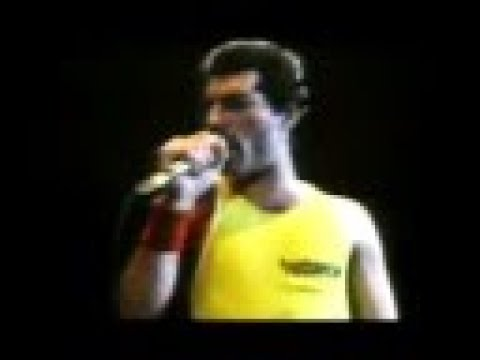

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('rY0WxgSXdEE', width=600, height=300)

**Note Onset Detection (NOD) methods**
> In literature, their are methids for of NOD **data-driven and non-data-driven**
methods. <br>
>> **Data driven** - methods build statistical models by using ML algos
on a large set of training data. For instance, learning a
probabilistic (hidden Markov) model exploiting the rhythmic regularity in music, training a neural network. These machine learning methods can either solve a classification problem, differentiating onsets from non-onsets, or a regression problem of which the output is then used
to estimate a suitable ODF( onset detection function )

>> **Non-Data driven** - methods, the ODF is directly calculated from the analyzed signal or its extracted features, they may operate in time or frequency domain and differ in the type of features extracted from the analyzed signal: magnitude, phase, energy, power spectral density, or time
derivatives of these.

state of art non-data-driven uses complex flux feature.

### Beat Track Detection (General Algorithm)

1. Measure onset strength <br>
<img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_1.png' width=250>
2. Tempo Estimation - from onset correlation <br>
<img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_2.png' width=250>
3. Pick peaks in onset strength approximately consistent with estimated tempo <br>
<img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_3.png' width=250>


### Measure onset strength 

**1. Spectogram (STFT)** <br>
> To detect node onset first step is to detect change in energy signature or frequency content, for that we apply STFT to convert signal into spectogram, below image describe magnitude of spectogram.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step1.png' width=450>

**2. Log compression** <br>
> Allow to adjust to dynamic range of the signal to enhance weaker spectral component specifically in high frequency range.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step2.png' width=450>

**3. Differentiation** <br>
> computing discreate derivative of above log compressed spectrum, in a row wise fashion for each frequency band separately. Only positive differeces are considered since we are interested in only energy increases.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step3.png' width=450>

**4. Accumalation** <br>
> All the positive differency obtained above are summed in column wise fashion which yield a single positive number at each point in time. As a result a curve is obtained which is also known as novality curve.
The peak indicate time position where major changes happended in spectrum.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step4.png' width=450>

> We compute a local average curve which is then subracted from novelity curve

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step5.png' width=450>

**5. Normalization** <br> Normalizing the novelity curve, peaks of novelity curves are good candidates for node onsets, as they signify positive energy changes.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step6.png' width=450>

**6. clipping peaks** <br>
> Peaks of the novelty curve are note onset candidates, we can use thresholding to extract node onset. Peak-picking is a very fragile step in particular for soft onsets (strings)

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/onset_step7.png' width=450>


summary - 

1. we calculated novelity curve to capture some signal properties like energy, spectrum
2. Energy based methods work for percussive music only
3. Peaks of the novelty curve indicate note onset candidates
4. Extraction of note onsets by peak-picking methods
(thresholding)

### Tempo Estimation

Objectives - 
*   It reveal periodic structure of the note onsets
*   Avoid the explicit determination of note onsets (no peak picking)
*   To Analyze the novelty curve with respect to periodicities


For tempo estimation we will make certain assumtion that in a certain time window beat occur in periodic fashion.


We are going to analyze the noveity curve for this periodic signals using
1. autocorrelation Tempogram
2. Fourier Tempogram

**autocorrelation tempogram**<hr>

<i>Grosche, Peter, Meinard Müller, and Frank Kurth. “Cyclic tempogram - A mid-level tempo representation for music signals.” ICASSP, 2010.</i>

**1. time shifted copies of novelity curve** - 

> Here we compare novelity curve with time shifted copies of itself. 

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step1.png' width=500>

**2. autocorrelation** -

> We take a window and compute autocorrelation while moving the window across the signal. 

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step2.png' width=900>

**3. correlation plot** -
>  The values obtained by correlation is autocorrelation plot, the correlation plot will provide

> a. high values in for time lags where their is a high correlation<br>
> b. Regions which are self similar are revieled

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step3.png' width=400>

**4. convert time-lag into tempo (BPM)**

> <pre> Tempo (in BPM ) = 60 / Lag (in sec) </pre>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step4.png' width=500>

**5. Interpolation** - 
> Interpolate to a linear tempo axis in a musically meaningful tempo range

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step5.png' width=400>


**6. Generating tempogram** - 

We will apply above principle of autocorrelation to estimate the tempo at every segment in the novelty function.

> Below figure specify that given value in tempogram point to given section in novelity curve

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step6.png' width=400>

> Here we will convert lag seconds into tempo (BPM) refer point 4, we can see that values highlighted in below figure are same values which we got in section 5.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step7.png' width=400>


> Rescaling the tempogram

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/temporal_step8.png' width=400>


**Fourier tempogram**<hr>

> The Fourier Tempogram is basically the magnitude spectrogram of the novelty function.

> Inorder to get Fourier tempogram compute the short-time Fourier transform (STFT) of the novelty function. Since the novelty function is computed in frame increments, the hop length of this STFT should be pretty small:

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_tempogram.png' width=400>

> Above Frequency axis is interpreted as tempo in BPM instead of
frequency in Hz

> For practical applications when computing Fourier tempogram (tf) using STFT we use only a small number of tempo parameters, eg [30:600] covering the (integer) musical tempi between 30 and 600 BPM

> The bounds are motivated by the assumption that only musical events showing a temporal separation between roughly  100 msec  ( 600 BPM ) and  2 sec  ( 30 BPM ) contribute to the perception of tempo. 

> a window size corresponding to  4  to  12 sec  of audio is a reasonable range.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step1.png' width=400>


> The visualization of fourier tempogram reveals dominant tempo over time.
> In above Fourier tempogram  reveals, the dominant tempo of this excerpt is between  200  and  300 BPM, the tempo slightly increases over time. the tempogram  also shows some larger coefficients that correspond to  1/3  and  2/3  of the main tempo.


> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step1.1.png' width=400>

> The idea of Fourier analysis is to detect local periodicities in novelty curve by comparing it with windowed sinusoids.

> A high correlation of a local section of novelty curve with a windowed sinusoid indicates a periodicity of the sinusoid's frequency (given a suitable phase).

> This correlation (along with the phase) can be computed using a short-time Fourier transform.

**Fourier vs Autocorrelation**<hr>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_vs_autocorrelation.png' width=600>


| Fourier Tempogram | Autocorrelation Tempogram |
| --- | --- |
| Compare the novelty curve with templates consisting of sinusoidal kernels each representing a specific tempo | Compare the novelty curve with time-shifted copies of itself |
| Reveals periodic sequences of peaks | Reveals periodic self-similarities|
| Emphasizes harmonics, i.e. multiples of the tempo: Tatum - Level |Emphasizes subharmonics, i.e. fractions of the tempo: Measure - Level |

###Beat tracking

**1. Local sinusoid** <br>
> Compute a single entry of tempogram by considering a suitable window sinusoid of correponsing frequency and then it is correlated with section of novelity curve. <br>

> Entry is defined by correlation value, in other words this value is magnitude of suitable fourier constant.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step2.png' width=400>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step3.png' width=400>
 
**2. Maximizing coefficient of window sinsoid** <br>
> For each time position or column we consider the maximizing coefficient (Each such coefficient defines a windowed sinusoid of local periodicity kernel, which in turn explain the local periodic behaviour of novelity curve)

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/tempo_1.png' width=400>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/tempo_2.png' width=400>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/tempo_3.png' width=400>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/tempo_4.png' width=400>

**3. Accumulate** <br>
> Accumulate all maximizing kernels over time, such as 1 kernel per frame. By above we will obtain a single curve

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step4.png' width=400>

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step5.png' width=400>

**4. halfwave rectification** <br>
> setting all -ve values to zero

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step6.png' width=400>

**5. Predominant Local Pulse (PLP)** <br>

> Original novelity curve is noisy, having peaks which are small and blurred.

> PLP curve is much more refined and also doesnt loose any original information, on the other hand it enhances certain peaks. It can recover weak onsets present in novelity curve. It captures sudden changes in local, meaning if in a music file suddently tempo increases PLP will be able to capture that due to accumulation and local periodicity kernel.

> It can be regarded as periodicity enhancement of original novelity curve.

> <img src='https://github.com/pankajr141/experiments/raw/master/images/audio_beattracking/fourier_step7.png' width=400>

| Novelity curve | Predominant Local Pulse (PLP) curve |
| --- | --- |
| Indicates note onset candidates | Periodic enhancement of novelity curve |
| Extraction err in particular soft onsets | Accumulation introduce error robustness |
| Simple peak picking problem | Locality of kernels handles tempo variations |


**6. Predominant Local Pulse (PLP) - modification**<br>

> one can improve PLP by introducing prior knowledge, one can restrict the peridicity kernel periodicity in certain range for example the kernel with range 100-150 ppm will be allowed in our PLP. <br>
increase duration of kernel (windows)

## Lets code

In [ ]:
import librosa
librosa.show_versions()

INSTALLED VERSIONS
------------------
python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

librosa: 0.8.1

audioread: 2.1.9
numpy: 1.21.6
scipy: 1.4.1
sklearn: 1.0.2
joblib: 1.1.0
decorator: 4.4.2
soundfile: 0.10.3
resampy: 0.2.2
numba: 0.51.2

numpydoc: None
sphinx: 1.8.6
sphinx_rtd_theme: None
sphinxcontrib.versioning: None
sphinx-gallery: None
pytest: 3.6.4
pytest-mpl: None
pytest-cov: None
matplotlib: 3.2.2
presets: None


In [ ]:
import matplotlib.pyplot as plt
from librosa import display
import numpy as np
import IPython

In [ ]:
filename = librosa.example('choice')

In [ ]:
IPython.display.Audio(filename)

**Loading Audio file**<hr>
loads and decodes the audio as a time series (frames_wave), sampling_rate (number of samples per second of audio)
By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional

In [ ]:
frames_wave, sampling_rate = librosa.load(filename)
print("frames_wave:", frames_wave.shape, "sampling_rate:", sampling_rate)

frames_wave: (551823,) sampling_rate: 22050


In [ ]:
hop_length = 200 # samples per frame
onset_env = librosa.onset.onset_strength(frames_wave, sr=sampling_rate, hop_length=hop_length, n_fft=2048)

In [ ]:
frames = range(len(onset_env))
frames_time = librosa.frames_to_time(frames, sr=sampling_rate, hop_length=hop_length)

### Plot Novelity curve

Text(0.5, 1.0, 'Novelty Function')

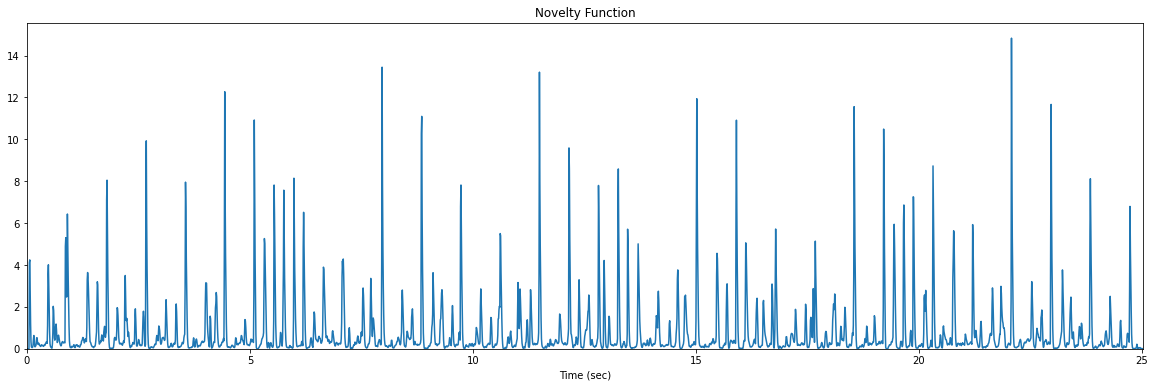

In [ ]:
figsize =(20, 6)
plt.figure(figsize=figsize)

plt.plot(frames_time, onset_env)  # plot onset_env

plt.xlim(0, frames_time.max())
plt.ylim(0)
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

### Plot Fourier Tempogram

Since the novelty function is computed in frame increments, the hop length of this STFT should be pretty small

In [ ]:
stft_novelity_curve = librosa.stft(onset_env, hop_length=1, n_fft=512)
fourier_tempogram = np.absolute(stft_novelity_curve)

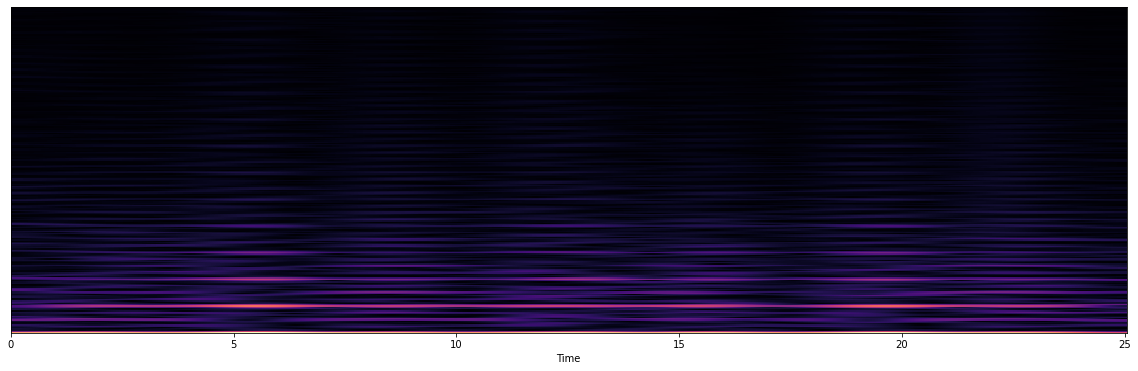

In [ ]:
plt.figure(figsize=(20, 6))
librosa.display.specshow(fourier_tempogram, sr=sampling_rate, hop_length=hop_length, x_axis='time')

### Plot Autocorrelation Tempogram

Consider a segment from the above novelty function:


In [ ]:
len(frames_time)

2760

Text(0.5, 1.0, 'Novelty Function')

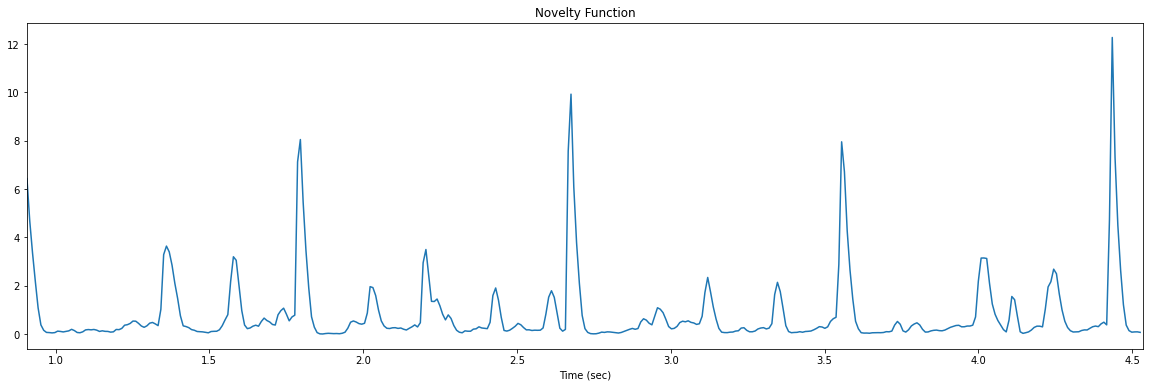

In [ ]:
n0 = 100
n1 = 500
plt.figure(figsize=(20, 6))
plt.plot(frames_time[n0:n1], onset_env[n0:n1])
plt.xlim(frames_time[n0], frames_time[n1])
plt.xlabel('Time (sec)')
plt.title('Novelty Function')

In [ ]:
log_novelity_function = np.log1p(onset_env[n0:n1])
autocorr_novelity_function = librosa.autocorrelate(log_novelity_function)

(0.0, 177.66184640120312)

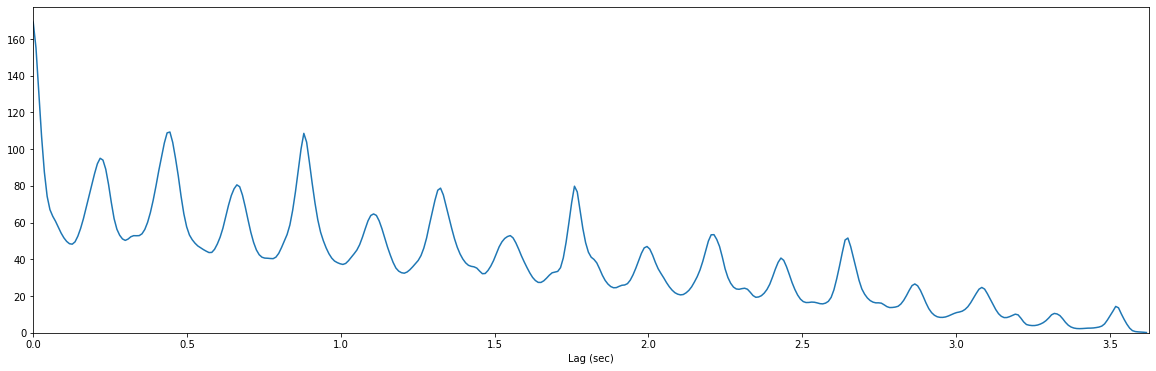

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(frames_time[:n1-n0], autocorr_novelity_function)
plt.xlim(frames_time[0], frames_time[n1-n0])
plt.xlabel('Lag (sec)')
plt.ylim(0)

Wherever the autocorrelation is high is a good candidate of the beat period.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(0.0, 162.9275689324168)

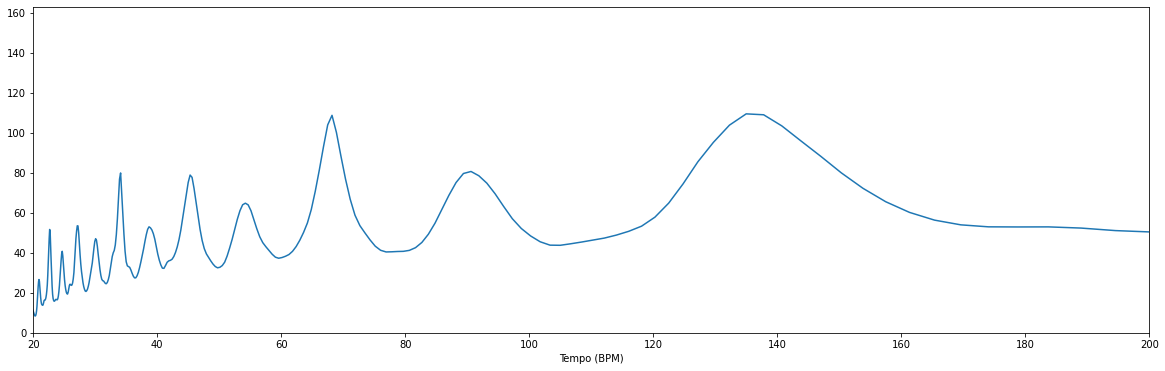

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(60/frames_time[:n1-n0], autocorr_novelity_function)
plt.xlim(20, 200)
plt.xlabel('Tempo (BPM)')
plt.ylim(0)

We will apply this principle of autocorrelation to estimate the tempo at every segment in the novelty function.



In [ ]:
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sampling_rate, hop_length=hop_length, win_length=400)

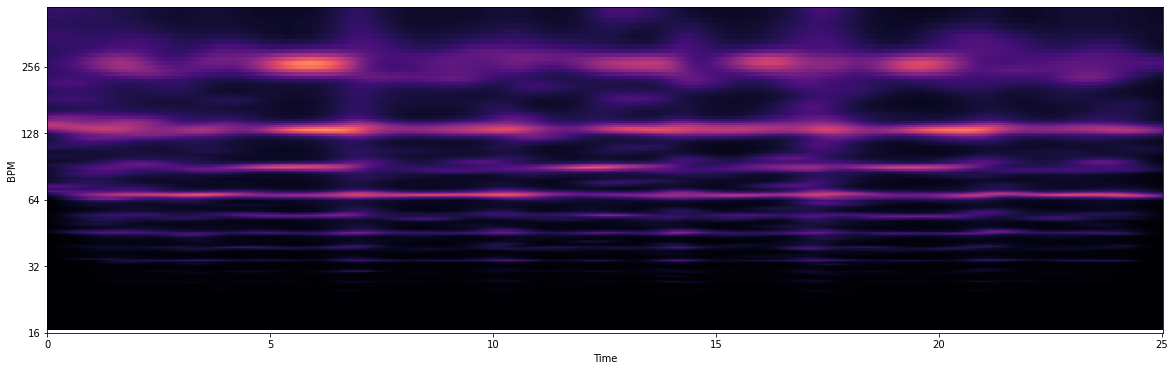

In [ ]:
plt.figure(figsize=(20, 6))
librosa.display.specshow(tempogram, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='tempo')

### Estimate global tempo

In [ ]:
tempo = librosa.beat.tempo(frames_wave, sr=sampling_rate)
print(tempo)

[135.99917763]


### Estimate Beat Track

In [ ]:
onset_env = librosa.onset.onset_strength(y=frames_wave, sr=sampling_rate, aggregate=np.median)

In [ ]:
# tempo, frames_beats = librosa.beat.beat_track(y=frames_wave, sr=sampling_rate)
# print("tempo:", tempo, "\nframes_beats:", frames_beats)

In [ ]:
tempo, frames_beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sampling_rate)
print("tempo:", tempo, "\nframes_beats:", frames_beats)

tempo: 135.99917763157896 
frames_beats: [   3   21   40   59   78   96  116  135  154  173  192  211  230  249
  268  287  306  325  344  363  382  401  420  439  458  476  495  515
  534  553  572  591  610  629  647  667  686  705  724  743  762  780
  799  819  838  857  876  895  914  933  951  971  990 1008]


In [ ]:
frames_beats_time = librosa.frames_to_time(frames_beats, sr=sampling_rate)
frames_beats_time

array([ 0.06965986,  0.48761905,  0.92879819,  1.36997732,  1.81115646,
        2.22911565,  2.69351474,  3.13469388,  3.57587302,  4.01705215,
        4.45823129,  4.89941043,  5.34058957,  5.78176871,  6.22294785,
        6.66412698,  7.10530612,  7.54648526,  7.9876644 ,  8.42884354,
        8.87002268,  9.31120181,  9.75238095, 10.19356009, 10.63473923,
       11.05269841, 11.49387755, 11.95827664, 12.39945578, 12.84063492,
       13.28181406, 13.7229932 , 14.16417234, 14.60535147, 15.02331066,
       15.48770975, 15.92888889, 16.37006803, 16.81124717, 17.2524263 ,
       17.69360544, 18.11156463, 18.55274376, 19.01714286, 19.458322  ,
       19.89950113, 20.34068027, 20.78185941, 21.22303855, 21.66421769,
       22.08217687, 22.54657596, 22.9877551 , 23.40571429])

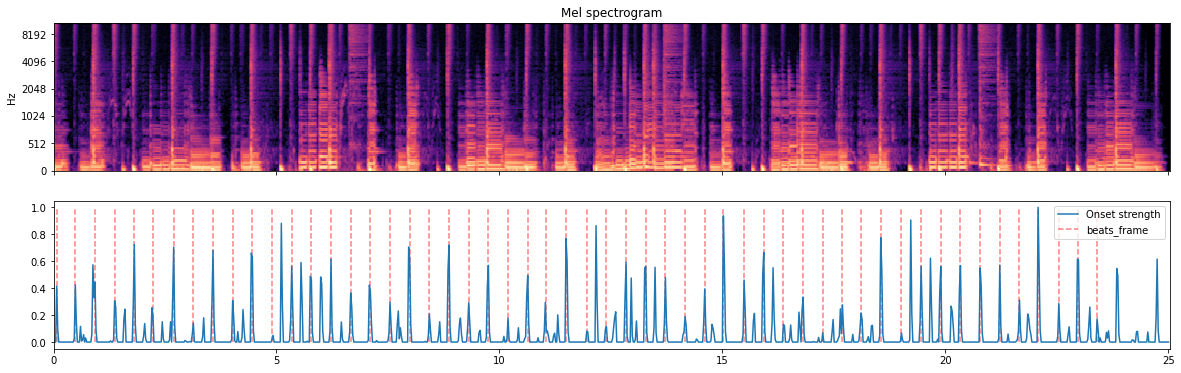

In [ ]:
hop_length = 512
figsize =(20, 6)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize, dpi=72)

times = librosa.times_like(onset_env, sr=sampling_rate, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=frames_wave, sr=sampling_rate, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])

ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].vlines(times[frames_beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='beats_frame')
ax[1].legend()

In [ ]:
IPython.display.Audio(frames_wave, rate=sampling_rate)

In [ ]:
clicks = librosa.clicks(frames_beats_time, sampling_rate, length=len(frames_wave))
IPython.display.Audio(frames_wave + clicks, rate=sampling_rate)

## References

> https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-021-00214-7.pdf

> https://librosa.org/doc/main/generated/librosa.onset.onset_backtrack.html

> https://librosa.org/doc/main/generated/librosa.beat.beat_track.html

> https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S2_TempogramFourier.html

> https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_OnsetDetection.html

> https://musicinformationretrieval.com/tempo_estimation.html

> https://www.youtube.com/watch?v=FmwpkdcAXl0